<a href="https://colab.research.google.com/github/ericbill21/siemens/blob/master/Siemens_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#@title Imports and config

# Tensorflow and Keras
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output

# Arithmetic Operations
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

# Progress calculation
import sys
import logging
import time

# time prediciton
PREV_TIME = 0

In [8]:
#@title Global constants

# Dictionaries
COLORS = {0 : 'green', 1 : 'red', 'green' : 0, 'red' : 1}
SOURCES = {'A' : 'https://drive.google.com/file/d/1hAzAKZNpmSclSI7HnV_cRjpMS4Kh5r1q/view?usp=sharing', 'B' : 'https://drive.google.com/file/d/12VlecL-5iYs-BFpnTOba1x65jWofBX1P/view?usp=sharing', 'C' : 'https://drive.google.com/file/d/1-Z0RuJIi1cZcqrrmV6TqT0O1PwI2OiBY/view?usp=sharing'}
SOURCE_SIZE = {'A': 1000,'B' : 5000, 'C' : 50000}

CURRENT_SET = 'B'

# Balancing dataset to threshold
THRESHOLD = 0.4

# Examlpe subsets of each dataset
subsetA = [47, 847, 993, 55, 102, 572, 430, 115, 842, 72, 770, 107, 78, 834, 593, 43, 234, 709, 210, 378]
#subsetB = [606, 2663, 1809, 2145, 4539, 3333, 3562, 2262, 512, 2046, 1541, 909, 286, 4815, 3663, 1742, 2822, 2756, 2937, 3080, 3845, 3949, 2506, 3984, 2803, 2067]
subsetC = [32088, 33534, 39634, 40177, 25142, 752, 41771, 11793, 16415, 3811, 2096, 35902, 42221, 19594, 25109, 40476, 25162, 41150, 34610, 28329, 46339, 43149, 44441, 25720, 38747, 49497, 12708, 23920, 2280, 17946]

subsetB = random.sample(range(5000), 800)

VAL_INDICES = locals()['subset' + CURRENT_SET]

# Penalty applied to false green classifications in custom loss function
PENALTY = 0.3

In [15]:
#@title Functions


def getDataSet():
  """Returns the dataset currently selected by CURRENT_SET."""
  path = 'https://drive.google.com/uc?export=download&id='+SOURCES[CURRENT_SET].split('/')[-2]
  return pd.read_excel(path)
  

def makePlot(dataSet = getDataSet(), correct_pred_points = [], incorrect_pred_points = []):
  """"Plots green and red points and markers as scatter graph.
  
  Args:
    dataSet: Optional; Expects pandas.DataFrame object with columns 'x_i1',
      'x_i2', 'l_i1'. Dataset to be plotted. Defaults to dataset selected by
      CURRENT_SET.
    correct_pred_points: Optional; Expects 2-dimensional list of shape (x,2)
      containing correctly predicted points. Marked as black 'x' on scatter
      graph.
    incorrect_pred_points: Optional; Expects 2-dimensional list of shape (x,2)
      containing incorrectly predicted points. Marked as black '*' on scatter
      graph.
  
  Raises:
    TypeError: If dataSet is not an instance of pd.DataFrame or the other
      parameters do not have the required shape.
  """

  # Checking for the right type
  if not isinstance(dataSet, pd.DataFrame):
    raise TypeError(f'dataSet is of type: {type(dataSet)}, but should be {pd.DataFrame}')

  # Checking for the right shape 
  if len(np.array(correct_pred_points).shape) != 2 and np.array(correct_pred_points).shape != (0,):
    raise TypeError(f'The shape of the parameter correct_pred_points is: \
      {np.array(correct_pred_points).shape}, but it should be 2 dimensional')
  
  if len(np.array(incorrect_pred_points).shape) != 2 and np.array(incorrect_pred_points).shape != (0,):
    raise TypeError(f'The shape of the parameter incorrect_pred_points is: \
      {np.array(incorrect_pred_points).shape}, but it should be 2 dimensional')
  
  # Creating a subplot
  fig, ax = plt.subplots()

  # Scattering all points
  for i in range(2):
    x_1 = np.array(dataSet['x_i1'].loc[dataSet['l_i'] == i])
    x_2 = np.array(dataSet['x_i2'].loc[dataSet['l_i'] == i])
    ax.scatter(x_1, x_2, c = COLORS[i])

  # Adding markers to the specified points
  ax.scatter(correct_pred_points[:, 0], correct_pred_points[:, 1],
             marker = "x", c = 'black', label='correct')
  ax.scatter(incorrect_pred_points[:, 0], incorrect_pred_points[:, 1],
             marker = "*", c = 'black', label='incorrect')

  # Setting parameters for ploting
  plt.legend()
  plt.xlabel('x_i1')
  plt.ylabel('x_i2')
  plt.title(f'DataSet {CURRENT_SET}')
  plt.axis('scaled')
  plt.show()


def seperateValidationSet(dataSet, validationIndices):
  """Formats a subset of points from a dataset as validation points.

  Validation points are extracted and deleted from dataSet to be used for
  validation later on.

  Args:
    dataSet: Expects pandas.DataFrame object with columns 'x_i1', 'x_i2', 'l_i1'.
      dataSet which the validation points are extracted from.
    validationIndices: Expects 1-dimensional list of integers. The elements
      corresponding to these indices are extracted from dataSet.
  Returns: 2-tuple of the form (valSet_points, valSet_labels), where valSet_points
    is a tensor of shape (x,2) and valSet_labels is a tensor of shape (x,1).
  """

  # Cheching for the right type
  if not isinstance(dataSet, pd.DataFrame):
    raise TypeError(f'dataSet is of type: {type(dataSet)}, but should be \
      {pd.DataFrame}')

  # Cheching for the right shape 
  if len(np.array(validationIndices).shape) != 1:
    raise TypeError(f'The shape of the parameter validationIndices is: \
      {np.array(validationIndices).shape}, but it should be 1 dimensional')
  
  valSet_points = []
  valSet_labels = []

  for i in validationIndices:
    valSet_points.append([dataSet['x_i1'].loc[i], dataSet['x_i2'].loc[i]])
    valSet_labels.append([dataSet['l_i'].loc[i]])
  
  #Saving the testing points
  valSet_points = tf.constant(valSet_points, tf.float32)
  valSet_labels = tf.constant(valSet_labels, tf.float32)

  #Removing the testing point
  dataSet.drop(index=validationIndices, inplace=True)
  dataSet.reset_index(inplace=True)

  return (valSet_points, valSet_labels)


def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1,
                     length = 100, fill = '█'):
  """Prints a progress bar.

  Args:
    iteration: Expects integer. Current progress step as. (iteration/total progress).
    total: Expects integer. Total progress steps until completion.
    prefix: Optional; Expects String. Printed infront of the progress bar.
    suffix: Optional; Expects String. Printed behind ETA.
    decimals: Optional; Expects integer. Number of decimal places of percentage
      progress.
    length: Optional; Expects integer. Length of the progress bar in characters.
    fill: Optional; Expects char. Filler of the progress bar.
  """

  # Preparing strings
  percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
  filledLength = int(length * iteration // total)
  bar = fill * filledLength + '-' * (length - filledLength)

  # Writing strings to console
  sys.stdout.write(f'\r{prefix} |{bar}| {percent}% ETA: {round(timeCalc()*(total-iteration), 2)} minutes {suffix}')
  sys.stdout.flush()

  # Erease progress bar on complete
  if iteration == total:
    global PREV_TIME
    PREV_TIME = 0
    sys.stdout.write('\r')
    sys.stdout.flush()




def makeCertaintyMap(model, accuracy = 100, specific_color = None):
  """Visualizes the prediction certainty of the model for a grid of data points.

  All data points have x and y values between 0 and 1. 

  Args:
    model: Expects a keras model. The model who's certainty is to be
      visualized.
    accuracy: Optional; Expects integer. Data points are spaced 1/accuracy apart
      along the x and y axis. The grid of data points plotted has the dimension
      accuracy*accuracy.
    specific_color: Optional; Expects 0 or 1. If 0, plots the model's certainty
      that a data point is green for all points in the grid. If 1, analogously 
      for red. 

  Raises:
    TypeError: If specific_color is not 'None', '0' or '1', or if accuracy is not
      an int.
  """
  #Exceptions
  if specific_color != None:
    if specific_color != 0 and specific_color != 1:
      raise TypeError(f'Invalid value for specific_color. Value is {specific_color}, \
        but should be "None", "0" or "1".')

  if not isinstance(accuracy, int):
    raise TypeError(f'Invalid type for accuracy. Type is {type(accuracy)}, but \
      should be int.')

  accuracy_map = np.zeros((accuracy, accuracy))

  for i in range(accuracy):
    tensor = tf.constant([[j/accuracy, i/accuracy] for j in range(accuracy)], tf.float32)
    result = model.predict(tensor)

    if specific_color != None:
      # Saving the prediction for the specified color
      accuracy_map[i] = result[:, specific_color]
    
    else:
      result = result.max(axis=1) #Getting each max value

      #Normalize the values which are between 0.5 <-> 1 to 0 <-> 1
      normalized = (result-0.5)/0.5
      accuracy_map[i] = normalized
  
    # Print current progress
    printProgressBar(i, accuracy-1)

  if specific_color != None:
    plt.title(f'Certaintiy for {COLORS[specific_color]}')
  else:
    plt.title(f'General Certainty')

  plt.imshow(accuracy_map, origin='lower', cmap='tab20b', vmin=0, vmax=1)
  plt.colorbar()
  plt.show()
  return accuracy_map



#TODO
def plotAllPenaltyCombinations(model, accuracy = 100):
  print('Chosen Subset:')
  makePlot(marker=valSet_points.numpy())

  result_x = np.zeros(accuracy+1)
  result_y = np.zeros(accuracy+1)

  printProgressBar(0, accuracy,prefix='Progress', suffix='ETA: ')

  #Iterating over every penalty
  for i in range(accuracy+1):
    keras.backend.clear_session()
    prevTime = time.time()

    penalty = i/accuracy #Selecting a value between 0 and 1 with steps of 1/accuracy

    model.compile(optimizer='adam',loss=construct_custom_penalty_loss(penalty),metrics=['accuracy'])
    model.fit(training_points, training_labels, batch_size=32, epochs=10, shuffle=True, verbose=0)
    
    #Saving results
    result_x[i] = penalty
    result_y[i] = model.evaluate(valSet_points, valSet_labels, verbose=0)[0]

    #Printing progress
    #printProgressBar(i+1, accuracy+1,prefix='Progress')

  #Presenting the results
  print('\nThe loss:')
  plt.plot(result_x, result_y)

  return result_y


def timeCalc():
  """Calculates time between previous call and current call.

  Returns:
    Time difference in minutes as float.
  """
  global PREV_TIME
  if PREV_TIME == 0:
    PREV_TIME = time.time()
    return 0
  
  res = (time.time() - PREV_TIME) / 60
  PREV_TIME = time.time()
  return res


def plotLoss(history):
  """Plots training loss and validation loss with respect to training epochs.

  Args:
    history: Expects keras History. history of keras model.
  """

  if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])

  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


def showPredicitons(model, valSet_points, valSet_labels):
  """Visualizes the predictions for the validation points.

  Args:
    model: Expects keras model. Model which performs the predictions.
    valSet_points: Expects tensor of shape (x,2). Data points used for validation.
    valSet_labels: Expects tensor of shape (x,1). Ground truth labels of the 
      validation points.

  Returns:
    2-dimensional numpy array of shape (x,2) with the predictions for the
    validation points.
  """
  # Predict the validation points
  prediction = model.predict(valSet_points)

  points = valSet_points.numpy()
  labels = valSet_labels.numpy()[:, 0].astype(int)

  # identifying the correct predicted points
  correct_indices = np.where((labels == np.argmax(prediction, axis=1)) == True)
  incorrect_indices = np.where((labels == np.argmax(prediction, axis=1)) == False)

  number_of_points = np.bincount(np.argmax(prediction, axis=1))

  num_misclassifications = np.bincount(labels == np.argmax(prediction, axis=1))[0]
  red_misclassifications = len(np.where(labels[incorrect_indices] == 1)[0])
  green_misclassifications = len(np.where(labels[incorrect_indices] == 0)[0])

  print(f'Predictions for green: {number_of_points[0]} / {len(labels)}')
  print(f'Predictions for red: {number_of_points[1]} / {len(labels)}')
  print(f'Points misclassified: {num_misclassifications}')
  print(f'Red points misclassified: {red_misclassifications}')
  print(f'Green points misclassified: {green_misclassifications}')

  makePlot(correct_pred_points=points[correct_indices], incorrect_pred_points=points[incorrect_indices])

  # Make bar graph showing red and green misclassifications
  bars = ('Red', 'Green')
  height = [red_misclassifications, green_misclassifications]
  x_pos = np.arange(len(bars))

  fig, ax = plt.subplots()
  ax.bar(x_pos, height, width=0.35, color=['red', 'green'])

  ax.set_ylabel('Misclassifications')
  ax.set_title('Misclassifications by color')
  ax.set_xticks(x_pos)
  ax.set_xticklabels(bars)

  rects = ax.patches # Array of bars

  labels = [red_misclassifications, green_misclassifications]

  for rect, label in zip(rects, labels): # Add labels above bars
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height, label,
              ha='center', va='bottom')

  plt.show()

  return prediction

  
def balanceDataset(dataSet, threshold):
  """Artificially balances dataSet by duplicating red or green points.

  Args: 
    dataSet: Expects pandas.DataFrame object with columns 'x_i1', 'x_i2', 'l_i1'.
      The dataset to be balanced.
    threshold: Expects float between 0 and 0.5. The function duplicates red or 
      green points until the fraction of points of the less frequent color is
      at least equal to the threshold.

  Returns:
    balanced dataset of shape (x,2)
  """

  total_number_of_points = dataSet.shape[0]
  number_of_green_points = dataSet.loc[dataSet["l_i"] == 0].shape[0]
  number_of_red_points = dataSet.loc[dataSet["l_i"] == 1].shape[0]

  amount = 0

  if number_of_red_points / total_number_of_points < threshold:
    amount = int( (threshold * total_number_of_points - number_of_red_points) // (1 - threshold) )
    red_points = dataSet.loc[dataSet['l_i'] == 1] #Getting all red points
    choooosen_points = red_points.sample(amount, replace=True) #Selecting a random subset of red points
    dataSet = dataSet.append(choooosen_points, ignore_index=True) #appending the subset

  if number_of_green_points / total_number_of_points < threshold:
    amount = int( (threshold * total_number_of_points - number_of_green_points) // (1 - threshold) )
    green_points = dataSet.loc[dataSet['l_i'] == 0] #Getting all green points
    choooosen_points = green_points.sample(amount, replace=True) #Selecting a random subset of green points
    dataSet = dataSet.append(choooosen_points, ignore_index=True) #appending green subset

  if 'index' in dataSet.columns:
    dataSet.pop('index') #removing old indices

  total_number_of_points = dataSet.shape[0]
  number_of_green_points = dataSet.loc[dataSet["l_i"] == 0].shape[0]
  number_of_red_points = dataSet.loc[dataSet["l_i"] == 1].shape[0]

  print(f'Artificially exended by {amount} points')
  print(f'Relation is now: {round(number_of_green_points / total_number_of_points, 2)}',
          f'green : {round(number_of_red_points / total_number_of_points, 2)} red ')
  
  return dataSet

In [10]:
#Preparing data
dataSet = getDataSet()
dataSet.pop('Unnamed: 0') #Removing unnessary column

valSet_points, valSet_labels = seperateValidationSet(dataSet=dataSet, validationIndices=VAL_INDICES)

dataSet = balanceDataset(dataSet, threshold=THRESHOLD)

#Creating tensors
training_labels = tf.constant(dataSet.pop('l_i'), tf.float32)
training_points = tf.constant(dataSet, tf.float32)

Artificially exended by 0 points
Relation is now: 0.47 green : 0.53 red 


In [11]:
#@title Custom Loss Function

def construct_custom_penalty_loss(penalty,
                                  lossFunction=keras.losses.sparse_categorical_crossentropy):
  """Constructs a loss function which penalizes 'red as green' misclassifications. 

  Args:
    penalty: Expects float between 0 and 1. Value added to the loss if a red
      point is misclassified as green. 
    lossFunction: Optional; Expects a loss function. The loss function used after
      adapting the loss values.

  Returns:
    custom_penalty_loss function with specified penalty and loss function. Can be
    used like a regular loss function. 
  """

  def custom_penalty_loss(y_true, y_pred):
    length = tf.shape(y_true)[0]

    #Creating a vector with all values set to the penalty: [0.3, 0.3, ... 0.3]
    error = tf.multiply(tf.constant(penalty, tf.float32), tf.ones(length)) 

    #Setting every entry to 0 if the corresponding entry in y_true is 1
    error = tf.where(tf.equal(y_true[:, 0], tf.zeros(length)), error, tf.zeros(length))

    #Setting every entry to 0 if the algorithm predicted 0
    error = tf.where(tf.greater(y_pred[:, 0], y_pred[:, 1]), tf.zeros(length), error)

    #Transforms the vector from [0, 0, 0.3, ... 0,3] to [[0, -0], [0, -0], [0.3, -0.3], ... [0.3, -0.3]]
    error = tf.stack([error, tf.multiply(tf.constant(-1, tf.float32), error)], 1)

    #Adding the artificial loss
    y_pred = y_pred + error

    #Eliminating values > 1 or < 0
    y_pred0 = tf.where(tf.greater(y_pred[:, 0], tf.ones(length)), tf.ones(length), y_pred[:, 0])
    y_pred1 = tf.where(tf.greater(y_pred[:, 1], tf.zeros(length)), y_pred[:, 1], tf.zeros(length))
    y_pred = tf.stack([y_pred0, y_pred1], axis=1)


    loss = lossFunction(y_pred=y_pred, y_true=y_true)
    return loss
  
  return custom_penalty_loss

In [12]:
initalizer = keras.initializers.GlorotNormal()

model = keras.Sequential([
           keras.layers.Flatten(input_shape=(2,)),      #input layer: 2 neurons
           keras.layers.Dense(100,activation='relu', kernel_initializer=initalizer), 
           keras.layers.Dense(70,activation='relu', kernel_initializer=initalizer), 
           keras.layers.Dense(50,activation='relu', kernel_initializer=initalizer),       
           keras.layers.Dense(10,activation='relu', kernel_initializer=initalizer),
           keras.layers.Dense(2,activation='softmax', kernel_initializer=initalizer)   #output layer: 2 neurons              
])


model.compile(optimizer='adam',loss=construct_custom_penalty_loss(PENALTY) ,metrics=['accuracy'])


history = model.fit(training_points, training_labels, batch_size=256, epochs=20000, shuffle=True, validation_data=(valSet_points, valSet_labels))
clear_output()

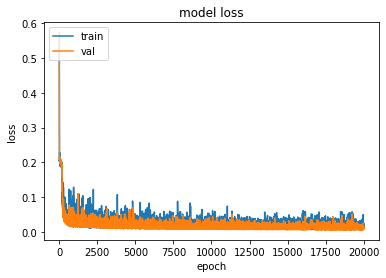

Predictions for green: 387 / 800
Predictions for red: 413 / 800
Points misclassified: 8
Red points misclassified: 0
Green points misclassified: 8


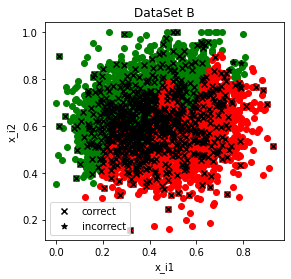

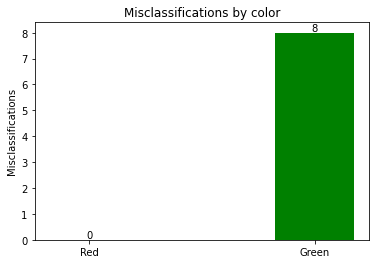

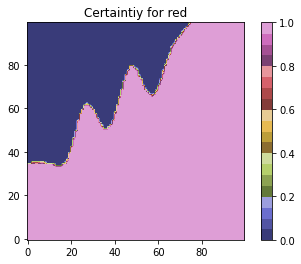

In [16]:
plotLoss(history)
x = showPredicitons(model, valSet_points, valSet_labels)
y = makeCertaintyMap(model, specific_color=1)

In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr  2 10:20:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |    547MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------